## Introduction

MNIST is the "hello world" of image classification. It is a dataset of handwritten digits taken mostly from United States Census Bureau employees. It is a set of images of digits 0-9, in grayscale and exactly identical dimensions, 28pixels x 28pixels. This serves as a relatively simple test for machine learning experiments and evaluating different models.

In this notebook, I explore convolutional neural networks using Keras. Specifically, learning rate annealing and data augmentation. While I expect to see fairly high accuracy, my primary objective here is to figure out the impact of these techniques on classification outcomes.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
from numpy import random

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, Callback
from keras import regularizers
from keras.optimizers import Adam


## visualize model using GraphViz
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#from keras.utils import plot_model

def display_images(X, y=[], rows=5, columns=5, cmap="gray"):
    """ Display images and labels
    """
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_axis_off()
            if len(y):ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
    fig.tight_layout()

%matplotlib inline

Using TensorFlow backend.


## Load, prepare and preview data

Our data looks like the sample below. It is a csv file with the true classification in the ```label``` column, followed by 784 pixel values (28x28 pixels unrolled). Each pixel takes a value ranging from 0-255. Since these are black and white images, each pixel is represented by a single value (channel) instead of three separate R, G, B values (3 channels) in a color image.

In [3]:
#df = pd.read_csv("../input/train.csv")
df = pd.read_csv("train.csv")
df.sample(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
23008,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We pick random samples from these 42000 images to create 3 sets - 
- training (60%): data used to train convnet
- cross validation (20%): data used to validate performance
- test (20%): data used to test classification accuracy

While there is a separate test set available, we are not using that in this notebook, since it is not labeled and cannot be easily evaluated.


In [4]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:].values, df.iloc[:,0].values, test_size = 0.4)
X_cv, X_test, y_cv, y_test = train_test_split(X_val, y_val, test_size = 0.5)
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

X_train:(25200, 784)
y_train:(25200,)

X_cv:(8400, 784)
y_cv:(8400,)

X_test:(8400, 784)
y_test:(8400,)


The data is in an unrolled format, i.e. each sample is a sequence of 784 pixel values. We will convert this using numpy's reshape function to (28x28x1). i.e. an image that is 28 pixels wide and 28 pixels tall, with 1 channel (black and white image).  So for example, the shape of the training set becomes (25200 samples, 28px, 28px, 1ch)

We change the output class (label) to categorical or one hot format. i.e. instead of a single value 0-9, we convert this to a array of size 10. e.g.
y = [9] becomes
y = [0,0,0,0,0,0,0,0,1,0]

Additionally, we scale all the features (pixel values) from a range of 0-255, to a range of 0-1. This is done by dividing each value in the feature matrix by 255.

Here are the new shapes of training, cross validation and test data sets.

In [5]:
width = 28
height = 28
channels = 1
X_train = X_train.reshape(X_train.shape[0], width, height, channels)
X_cv = X_cv.reshape(X_cv.shape[0], width, height, channels)
X_test = X_test.reshape(X_test.shape[0], width, height, channels)

# convert output classes to one hot representation
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_cv = np_utils.to_categorical(y_cv, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

X_train = X_train.astype('float32')
X_cv = X_cv.astype('float32')
X_test = X_test.astype('float32')

# Scale features (pixel values) from 0-255, to 0-1 
X_train /= 255
X_cv /= 255
X_test /= 255
print("Reshaped:")
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

Reshaped:
X_train:(25200, 28, 28, 1)
y_train:(25200, 10)

X_cv:(8400, 28, 28, 1)
y_cv:(8400, 10)

X_test:(8400, 28, 28, 1)
y_test:(8400, 10)


Here is a preview of a few images in the training set.

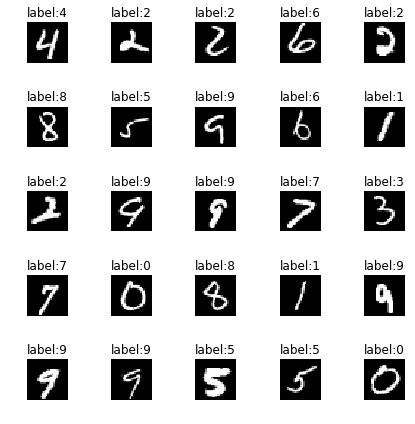

In [6]:
display_images(X_train, y_train)

In [7]:
batch_size=42
epochs=30
verbose=2

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


def create_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), padding="same", activation='relu', input_shape=(width, height, channels) ))
    model.add(Conv2D(32, (5,5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    opt = "adam" #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def plot_metrics(h, title=""):
    """ Plot training metrics - loss and accuracy, for each epoch, 
        given a training history object
    """
    fig, axes = plt.subplots(1,2, figsize=(10,5))
      
    axes[0].plot(h.history['loss'], color="lightblue", label="Training", lw=2.0)
    axes[0].plot(h.history['val_loss'], color="steelblue", label="Validation", lw=2.0)

    axes[0].set_title("{} (Loss)".format(title))
    axes[0].set_xlabel("Epoch")
    axes[0].set_xticks(np.arange(len(h.history["loss"]), 2))
    axes[0].set_ylabel("Loss")
    
    axes[1].plot(h.history['acc'], color="lightblue", label="Training", lw=2.0)
    axes[1].plot(h.history['val_acc'], color="steelblue", label="Validation", lw=2.0)
    
    axes[1].set_title("{} (Accuracy)".format(title))
    axes[1].set_xlabel("Epoch")
    axes[1].set_xticks(np.arange(len(h.history["acc"]), 2))
    axes[1].set_ylabel("Accuracy")
    

    for axis in axes:
        axis.ticklabel_format(useOffset=False)
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.legend(loc='best', shadow=False)
    fig.tight_layout()
    
def plot_losses(batch_hist, title=""):
    fig, ax1 = plt.subplots()

    ax1.semilogx(batch_hist.losses)
    ax1.set_title("{} (Batch Loss)".format(title))  
    
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    plt.show()

## Model Definition

I use this model as the starting point, built using Keras sequential API. I create 3 separate instances of this model and then compare results with learning rate annealing and image data augmentation. 

Keras also provides a easy way to generate this diagram from the model. See code below.

<img src="https://raw.githubusercontent.com/vinayshanbhag/keras-cnn-mnist/master/model.png"/>

In [8]:
model0 = create_model()

# Visualize model using GraphViz
#plot_model(model0, show_shapes=True, show_layer_names=False,to_file='model.png')

model0_batch_hist = LossHistory()

model0_metrics = model0.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = verbose, shuffle=True, callbacks=[model0_batch_hist])

#model0.save_weights("model0.h5")

Train on 25200 samples, validate on 8400 samples
Epoch 1/30
8s - loss: 0.3074 - acc: 0.9006 - val_loss: 0.0621 - val_acc: 0.9812
Epoch 2/30
6s - loss: 0.1018 - acc: 0.9690 - val_loss: 0.0585 - val_acc: 0.9817
Epoch 3/30
6s - loss: 0.0821 - acc: 0.9747 - val_loss: 0.0467 - val_acc: 0.9854
Epoch 4/30
6s - loss: 0.0657 - acc: 0.9799 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 5/30
6s - loss: 0.0548 - acc: 0.9828 - val_loss: 0.0457 - val_acc: 0.9864
Epoch 6/30
6s - loss: 0.0551 - acc: 0.9830 - val_loss: 0.0358 - val_acc: 0.9889
Epoch 7/30
6s - loss: 0.0455 - acc: 0.9865 - val_loss: 0.0364 - val_acc: 0.9881
Epoch 8/30
6s - loss: 0.0429 - acc: 0.9862 - val_loss: 0.0315 - val_acc: 0.9900
Epoch 9/30
6s - loss: 0.0426 - acc: 0.9865 - val_loss: 0.0287 - val_acc: 0.9908
Epoch 10/30
6s - loss: 0.0361 - acc: 0.9885 - val_loss: 0.0397 - val_acc: 0.9882
Epoch 11/30
6s - loss: 0.0371 - acc: 0.9877 - val_loss: 0.0253 - val_acc: 0.9933
Epoch 12/30
6s - loss: 0.0333 - acc: 0.9895 - val_loss: 0.0290 - val_

## Learning Rate Annealing

Learning rate is the step size in gradient descent. If the step size is too large, the system may oscillate chaotically. On the other hand, if the step size is too small, it may take too long or may settle on a local minimum. 

<p style="float: left;">We will watch validation accuracy in each epoch, and reduce the learning rate to a third, if it plateaus in 2 consecutive epochs. Keras provides an aptly named, ```ReduceLROnPlateau```, callback to adapt the learning rate based on results from each epoch. Ref: [```ReduceLROnPlateau```](https://keras.io/callbacks/#reducelronplateau) for more options.</p>

<p style="float: left">The verbose mode, allows us to see when this actually kicks in.</p>

In [9]:
learning_rate_controller = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=verbose, factor=0.3, min_lr=0.00001, epsilon=0.001)

## Model with learning rate annealer

We create a new instance of the same model, but this time, insert a callback to our learning rate control function defined above. Then fit the model to our training data set and collect metrics.

In [10]:
model1 = create_model()
model1_batch_hist = LossHistory()
model1_metrics = model1.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = verbose, shuffle=True, callbacks=[learning_rate_controller,model1_batch_hist])
#model1.save_weights("model1.h5")

Train on 25200 samples, validate on 8400 samples
Epoch 1/30
6s - loss: 0.3136 - acc: 0.8987 - val_loss: 0.0711 - val_acc: 0.9788
Epoch 2/30
6s - loss: 0.1051 - acc: 0.9677 - val_loss: 0.0516 - val_acc: 0.9842
Epoch 3/30
6s - loss: 0.0783 - acc: 0.9768 - val_loss: 0.0434 - val_acc: 0.9865
Epoch 4/30
6s - loss: 0.0665 - acc: 0.9806 - val_loss: 0.0370 - val_acc: 0.9886
Epoch 5/30
6s - loss: 0.0600 - acc: 0.9815 - val_loss: 0.0359 - val_acc: 0.9892
Epoch 6/30
6s - loss: 0.0547 - acc: 0.9823 - val_loss: 0.0445 - val_acc: 0.9864
Epoch 7/30
6s - loss: 0.0486 - acc: 0.9852 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 8/30
6s - loss: 0.0457 - acc: 0.9856 - val_loss: 0.0345 - val_acc: 0.9898
Epoch 9/30
6s - loss: 0.0397 - acc: 0.9880 - val_loss: 0.0303 - val_acc: 0.9910
Epoch 10/30

Epoch 00009: reducing learning rate to 0.0003000000142492354.
6s - loss: 0.0395 - acc: 0.9881 - val_loss: 0.0340 - val_acc: 0.9905
Epoch 11/30
6s - loss: 0.0246 - acc: 0.9919 - val_loss: 0.0265 - val_acc: 0.9912
Epoch 

## Data Augmentation
To improve classification accuracy, we can augment the training samples, with random transformations of images in the training set. In Keras, this is done using ```keras.preprocessing.image.ImageDataGenerator``` class. We can apply random transformations such as, zooming, rotation, shifting the image up/down. We will limit rotation to a few degrees, and disable horizontal and vertical flipping, as our dataset of digits is prone to produce ambiguous results with these operations. 

See [```ImageDataGenerator```](https://keras.io/preprocessing/image/#imagedatagenerator) for lots of other options that are useful for other types of images.

In [11]:
idg = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.05, 
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

Here are a few images produced by the image data generator.

Sample images from ImageDataGenerator:


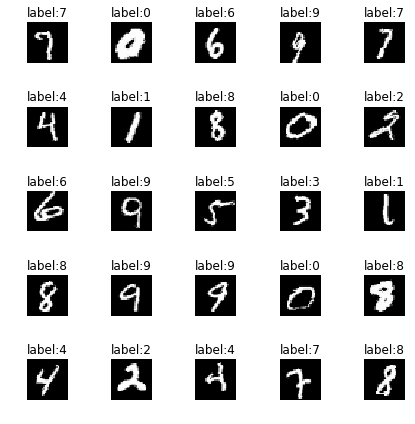

In [12]:
image_data = idg.flow(X_train,y_train, batch_size=25).next()
print("Sample images from ImageDataGenerator:")
display_images(image_data[0], image_data[1])

## Model with data augmentation

We create yet another instance of the model we defined earlier with learning rate annealer. This time instead of fitting it to the training data set, we will instead fit it to the images generated by the ```ImageDataGenerator```. We will collect loss and accuracy metrics for comparison.

In [13]:
model2 = create_model()
model2_batch_hist = LossHistory()
model2_metrics = model2.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    validation_data=(X_cv,y_cv),
                    callbacks=[learning_rate_controller,model2_batch_hist],                         
                    verbose = verbose)
#model2.save_weights("model2.h5")

Epoch 1/30
6s - loss: 0.4010 - acc: 0.8686 - val_loss: 0.0720 - val_acc: 0.9781
Epoch 2/30
6s - loss: 0.1541 - acc: 0.9515 - val_loss: 0.0617 - val_acc: 0.9811
Epoch 3/30
6s - loss: 0.1196 - acc: 0.9633 - val_loss: 0.0430 - val_acc: 0.9873
Epoch 4/30
6s - loss: 0.1078 - acc: 0.9676 - val_loss: 0.0352 - val_acc: 0.9892
Epoch 5/30
6s - loss: 0.0890 - acc: 0.9717 - val_loss: 0.0337 - val_acc: 0.9900
Epoch 6/30
6s - loss: 0.0885 - acc: 0.9731 - val_loss: 0.0364 - val_acc: 0.9894
Epoch 7/30
6s - loss: 0.0796 - acc: 0.9768 - val_loss: 0.0294 - val_acc: 0.9919
Epoch 8/30
6s - loss: 0.0720 - acc: 0.9778 - val_loss: 0.0251 - val_acc: 0.9929
Epoch 9/30
6s - loss: 0.0705 - acc: 0.9789 - val_loss: 0.0271 - val_acc: 0.9918
Epoch 10/30
6s - loss: 0.0644 - acc: 0.9797 - val_loss: 0.0336 - val_acc: 0.9896
Epoch 11/30

Epoch 00010: reducing learning rate to 0.0003000000142492354.
6s - loss: 0.0672 - acc: 0.9797 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 12/30
6s - loss: 0.0480 - acc: 0.9852 - val_loss:

## Comparing the loss functions

Plot loss function over all batches, for each of the 3 models. The learning rate annealer appears to make it slightly less noisy. 

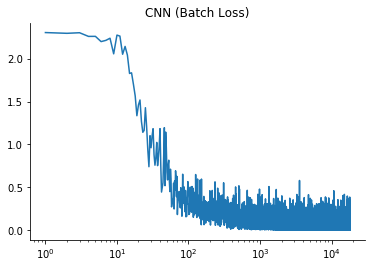

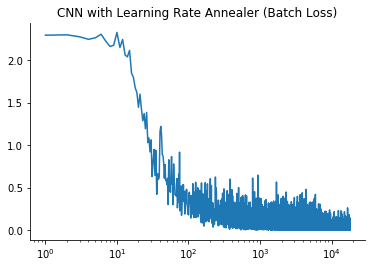

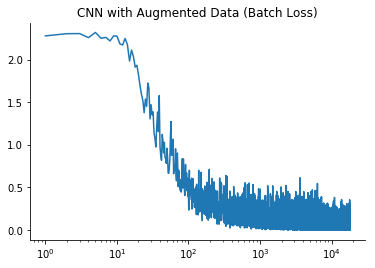

In [14]:
plot_losses(model0_batch_hist, "CNN")
plot_losses(model1_batch_hist, "CNN with Learning Rate Annealer")
plot_losses(model2_batch_hist, "CNN with Augmented Data")

## Results

Plotted below are the loss and accuracy metrics on training and validation data from the three models.

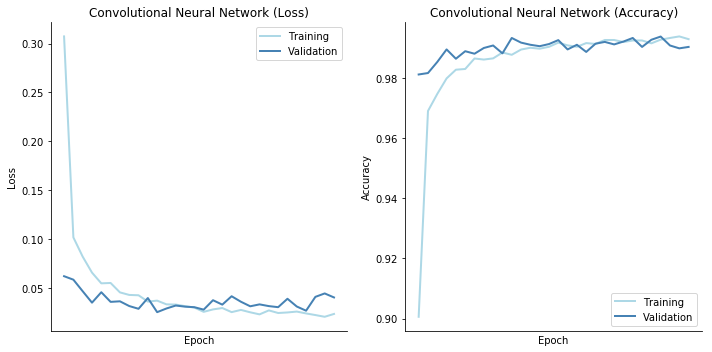

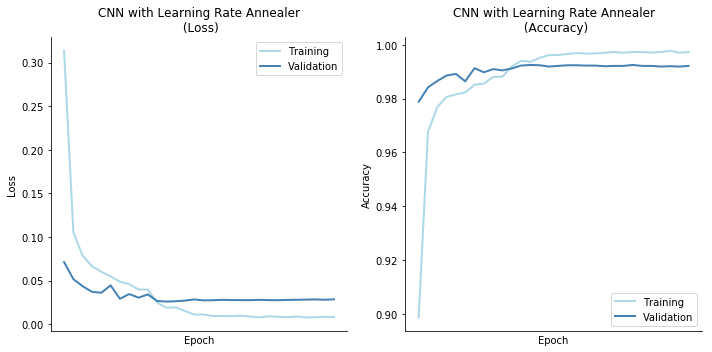

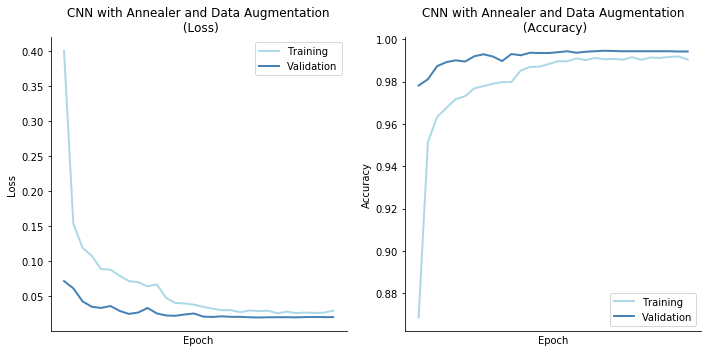

In [15]:
plot_metrics(model0_metrics,"Convolutional Neural Network")
plot_metrics(model1_metrics,"CNN with Learning Rate Annealer\n")
plot_metrics(model2_metrics,"CNN with Annealer and Data Augmentation\n")

## Classification Accuracy

Here is a summary of how the three models performed in terms of training, validation and test accuracy.

Model,Training Accuracy,Validation Accuracy,Test Accuracy
Convolutional Neural Network,99.29,99.04,99.29
CNN + Learning Rate Annealing,99.73,99.21,99.33
CNN + LR + Data Augmentation,99.04,99.42,99.50


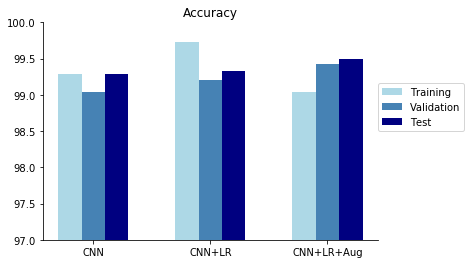

In [16]:
models = [model0, model1, model2]
metrics = [model0_metrics, model1_metrics, model2_metrics]
names = ["Convolutional Neural Network", "CNN + Learning Rate Annealing", "CNN + LR + Data Augmentation"
         ]
data = []
for i, m in enumerate(zip(names, metrics, models)):
    data.append([m[0], "{:0.2f}".format(m[1].history["acc"][-1]*100), "{:0.2f}".format(m[1].history["val_acc"][-1]*100), "{:0.2f}".format(m[2].evaluate(X_test, y_test, verbose=0)[1]*100)])

results = pd.DataFrame(data, columns=("Model","Training Accuracy","Validation Accuracy", "Test Accuracy"))
from IPython.display import display, HTML
display(HTML(results.to_html(index=False)))
plt.bar(np.arange(len(results["Model"].values)),results["Training Accuracy"].values.astype("float64"), 0.2, color="lightblue")
plt.bar(np.arange(len(results["Model"].values))+0.2,results["Validation Accuracy"].values.astype("float64"), 0.2, color="steelblue")
plt.bar(np.arange(len(results["Model"].values))+0.4,results["Test Accuracy"].values.astype("float64"), 0.2, color="navy")
plt.ylim(97, 100)
plt.xticks(np.arange(len(results["Model"].values))+0.2, ["CNN","CNN+LR", "CNN+LR+Aug"])
plt.legend(["Training","Validation", "Test"],loc=(1,0.5))
g = plt.gca()
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
plt.title("Accuracy")

#### Work In Progress